In [1]:
import pandas as pd

# Load the dataset from the Excel file
dataset_filename = r"C:\Users\hp\Downloads\updated_combinational_logic_depth_dataset.xlsx"
df = pd.read_excel(dataset_filename)

# Display a preview of the dataset
print("Dataset preview:")
print(df.head())

Dataset preview:
     Signal  Fan-In  Fan-Out  Gate Count  Gate Delay (ns)  Line Delay (ns)  \
0  signal_0      13        2          75         1.883380         0.511851   
1  signal_1      12       10          57         0.354556         0.147569   
2  signal_2       8        7          72         0.482566         0.176028   
3  signal_3       7        1          93         1.128659         0.583292   
4  signal_4       2       11          35         0.990291         0.737936   

   Transition Delay (ns)  Logic Depth (ns)  Delay per Gate (ns)  \
0               0.292846        149.233012             1.883380   
1               0.095488          9.924519             0.354556   
2               0.088160         36.010420             0.482566   
3               0.061892        115.748266             1.128659   
4               0.034708         42.924595             0.990291   

   Fan Complexity  
0              26  
1             120  
2              56  
3               7  
4          

In [2]:
# Display dataset information to check data types and missing values
print("\nDataset Info:")
print(df.info())

# If there's an identifier column like 'Signal', drop it since it's not useful for training
if 'Signal' in df.columns:
    df = df.drop(columns=['Signal'])


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Signal                 1500 non-null   object 
 1   Fan-In                 1500 non-null   int64  
 2   Fan-Out                1500 non-null   int64  
 3   Gate Count             1500 non-null   int64  
 4   Gate Delay (ns)        1500 non-null   float64
 5   Line Delay (ns)        1500 non-null   float64
 6   Transition Delay (ns)  1500 non-null   float64
 7   Logic Depth (ns)       1500 non-null   float64
 8   Delay per Gate (ns)    1500 non-null   float64
 9   Fan Complexity         1500 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 117.3+ KB
None


In [3]:
# Derived feature: Fan Complexity = Fan-In * Fan-Out
df['Fan Complexity'] = df['Fan-In'] * df['Fan-Out']

# (Optional) You can add other derived features if needed.
?


IPython -- An enhanced Interactive Python

IPython offers a fully compatible replacement for the standard Python
interpreter, with convenient shell features, special commands, command
history mechanism and output results caching.

At your system command line, type 'ipython -h' to see the command line
options available. This document only describes interactive features.

GETTING HELP
------------

Within IPython you have various way to access help:

  ?         -> Introduction and overview of IPython's features (this screen).
  object?   -> Details about 'object'.
  object??  -> More detailed, verbose information about 'object'.
  %quickref -> Quick reference of all IPython specific syntax and magics.
  help      -> Access Python's own help system.

If you are in terminal IPython you can quit this screen by pressing `q`.


MAIN FEATURES
-------------

* Access to the standard Python help with object docstrings and the Python
  manuals. Simply type 'help' (no quotes) to invoke it.

* Ma

In [4]:
# Define the feature columns we want to use for training
features = [
    'Fan-In', 
    'Fan-Out', 
    'Gate Count', 
    'Gate Delay (ns)', 
    'Line Delay (ns)', 
    'Transition Delay (ns)', 
    'Delay per Gate (ns)', 
    'Fan Complexity'
]

# Our target variable is the Logic Depth (ns)
X = df[features]
y = df["Logic Depth (ns)"]

print("\nFeatures used for training:")
print(X.columns.tolist())



Features used for training:
['Fan-In', 'Fan-Out', 'Gate Count', 'Gate Delay (ns)', 'Line Delay (ns)', 'Transition Delay (ns)', 'Delay per Gate (ns)', 'Fan Complexity']


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Create a pipeline for numeric data preprocessing:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),      # Fill missing values
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # Expand features (optional, helps capture non-linearities)
    ("scaler", StandardScaler())                         # Standardize features
])

# Fit and transform our feature matrix
X_processed = numeric_pipeline.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.20, random_state=42)

print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")



Training samples: 1200, Testing samples: 300


In [7]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.005,
    max_depth=11,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    random_state=42
)

gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.005,
    max_depth=9,
    random_state=42
)


In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('gbr', gbr_model)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble
stacking_reg.fit(X_train, y_train)
print("\nStacking ensemble training complete!")


Stacking ensemble training complete!


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test set using the stacking ensemble
y_pred_stack = stacking_reg.predict(X_test)

# Calculate performance metrics
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\nStacking Ensemble MAE: {mae_stack:.4f}")
print(f"Stacking Ensemble R²: {r2_stack:.4f}")


Stacking Ensemble MAE: 4.1248
Stacking Ensemble R²: 0.9864


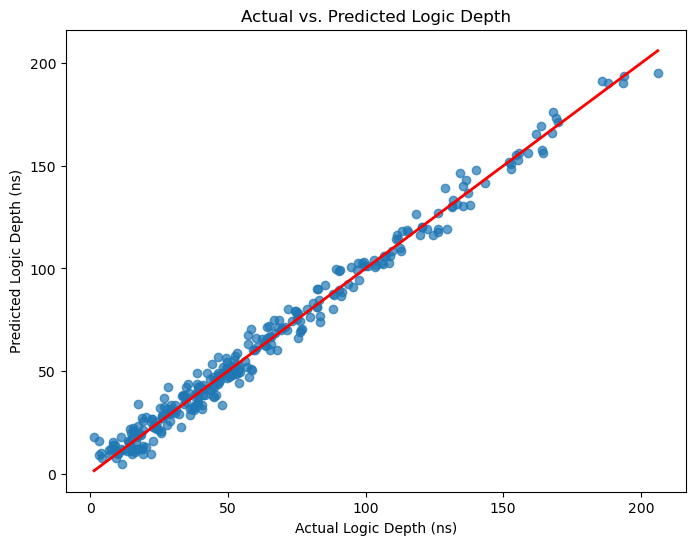

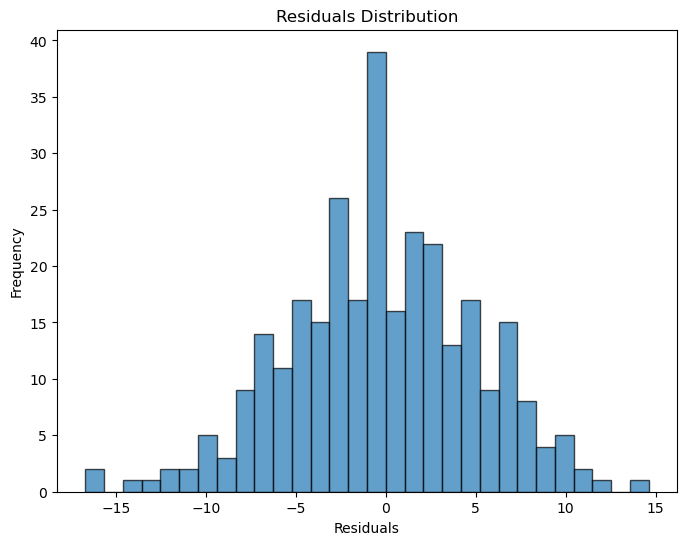

In [10]:
import matplotlib.pyplot as plt

# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_stack, alpha=0.7)
plt.xlabel("Actual Logic Depth (ns)")
plt.ylabel("Predicted Logic Depth (ns)")
plt.title("Actual vs. Predicted Logic Depth")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.show()

# Residual histogram
residuals = y_test - y_pred_stack
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()


In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def test_prediction_shape(model, X_test):
    """
    Test that the model returns the correct number of predictions.
    """
    # Get predictions from the model
    predictions = model.predict(X_test)
    
    # Check that the number of predictions matches the number of test samples
    assert predictions.shape[0] == X_test.shape[0], (
        f"Expected {X_test.shape[0]} predictions, but got {predictions.shape[0]}"
    )
    print("Test Case Passed: Prediction shape is correct.")

# Example usage assuming your model is stored in 'stacking_reg' and your test data is in X_test.
test_prediction_shape(stacking_reg, X_test)


Test Case Passed: Prediction shape is correct.


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

def test_model_performance(model, X_test, y_test, expected_mae=10, expected_r2=0.9):
    """
    Test that the model's performance meets expected thresholds.
    Adjust expected_mae and expected_r2 based on your performance criteria.
    """
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Check if performance is within acceptable limits.
    assert mae < expected_mae, f"MAE is too high: {mae:.4f} (threshold: {expected_mae})"
    assert r2 > expected_r2, f"R² score is too low: {r2:.4f} (threshold: {expected_r2})"
    
    print(f"Test Passed: Model performance is acceptable (MAE: {mae:.4f}, R²: {r2:.4f}).")

# Run this test case with your trained model
test_model_performance(stacking_reg, X_test, y_test, expected_mae=10, expected_r2=0.9)

Test Passed: Model performance is acceptable (MAE: 4.1248, R²: 0.9864).
